# [HACKATHON in Grenoble 03.10.2024] - Turbidity Mapping project 
## Team: Shashank, Nga, Fabio, Minh

**Objective**: From satellite  incomplete observation data having Gaussian noise of Ducht Wadden Sea, we aim at reconstructing states of Suspended Particulate Matter (SPM) fields using 4DVarNet 

<!-- 
![4DVarNet Workflow](./images/4dVarNet_workflow.png) -->

<div style="text-align: center;">
    <img src="4dVarNet_workflow.png" alt="4DVarNet Workflow" style="width: 80%;"/>
    <p><b>Figure 1:</b> 4DVarNet Workflow</p>
</div>

### 4DVarNet Loss formulation ###
We aim to minimize the 4DVar Loss function as residual error of reconstruction data and observation data. Note that in this scope of notebook file we do not retrain the model,  we would load the pretrained model instead.
$$
\text{arg}\text{min}_x \, \mathcal{U}(x, y; \Omega) = \text{arg}\text{min}_x \, \lambda_1 || x - y ||^2_{\Omega} + \lambda_2 ||x - \phi(x)||^2
$$

$x$: reconstruction stage

$y$: imcomplete observations 

$\Omega$: observation mask 

$\phi(.)$: dynamical model

In [1]:
import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
import datamodule
from model_AE_Bilin3D import model_AE as model_AE_3D
from iter_solver import Model_4DVarNN_GradFP
import time
from tqdm import tqdm

## [Step 1]: Loading data to dataloader
### Loading data of Dutch Wadden Sea of 1-month  observational dataset from 01.02.2018 to 28.02.2018 

In [2]:
# Load the (artificially) observation data
sat_data = xr.open_dataset(f'data/new_CMEMS_artificial_clouds_2018_02.nc')
# Load the ground truth data
ground_truth_data = xr.open_dataset(f'data/new_CMEMS_2018_02.nc')
# Load the land mask 
landmask = xr.open_dataset(f'data/landmask.nc')

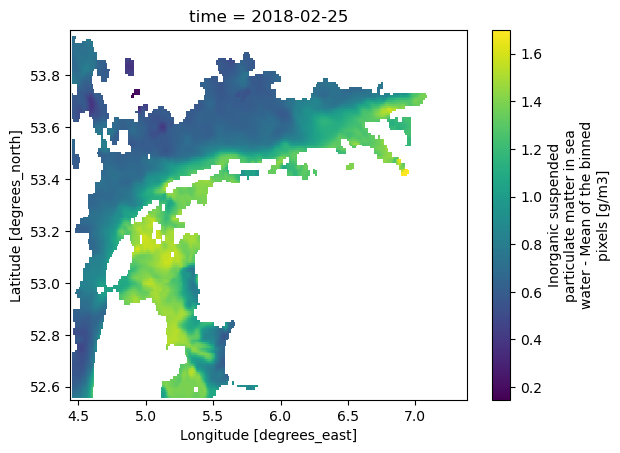

In [3]:
# Visualization example of one day of the ground truth dataset
ground_truth_data.sel(time = '2018-02-25').SPM.plot()

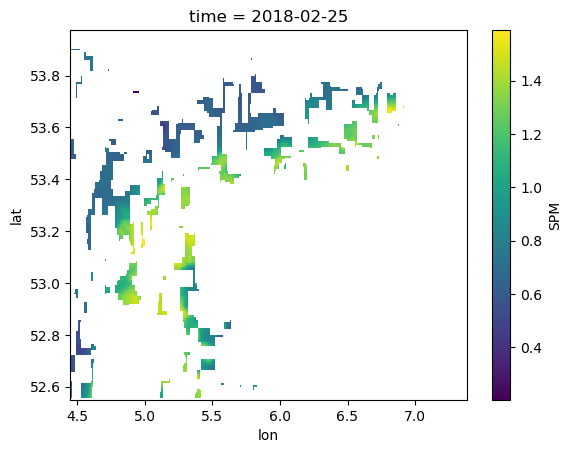

In [4]:
# Visualization example of one day of the artificially masked dataset
sat_data.sel(time = '2018-02-25').SPM.plot()

### Setting up the dataloder 

In [5]:
input_da = datamodule.load_bbp_data(GT=ground_truth_data, patch=sat_data)
config = {
    'input_da': input_da,
    'domains': {
        'train': {'time': slice('2018-02-01', '2018-02-28')},
        'val': {'time': slice('2018-02-01', '2018-02-28')},
        'test': {'time': slice('2018-02-01', '2018-02-28')}
    },
    'xrds_kw': {
        'patch_dims': {'time': 10, 'lat': len(sat_data.lat.data), 'lon': len(sat_data.lon.data)},
        'strides': {'time': 1, 'lat': len(sat_data.lat.data), 'lon': len(sat_data.lon.data)}
    },
    'dl_kw': {'batch_size': 1, 'num_workers': 1},
    'aug_factor': 1,
    'aug_only': True
}
# Instantiate the DataModule with the configuration
data_module = datamodule.BaseDataModule(**config)
# Creating the dataloader
data_module.setup()

meanTr, stdTr = data_module.norm_stats()

test_dataloader = data_module.test_dataloader()

dataloaders = {
    'test': test_dataloader
}

dataset_sizes = {'test': len(test_dataloader)}

# Corresponding dataset
test_ds  = data_module.masked_test_ds()

## [Step 2]: Load pre-trained 4DVarNet composed of LSTM and AutoEncoder models ##

In [6]:
UsePriodicBoundary = True 
InterpFlag         = False

patch_size = config['xrds_kw']['patch_dims']['time']
batch_size = config['dl_kw']['batch_size']
lat = sat_data['lat']
lon = sat_data['lon']
shapeData = np.array((batch_size, patch_size, len(lat), len(lon)))
DimState = 96

alpha          = np.array([1.,0.1])

IterUpdate     = [0,100,200,500,2000,1000,1200]#[0,2,4,6,9,15]
NbProjection   = [0,0,0,0,0,0,0]#[0,0,0,0,0,0]#[5,5,5,5,5]##
#bGradIter     = [1, 1]#
NbGradIter     = [15,15]#[0,0,1,2,3,3]#[0,2,2,4,5,5]#
lrUpdate       = [1e-3,1e-4,1e-4,1e-5,1e-5,1e-4,1e-5,1e-6,1e-7]

NBGradCurrent   = NbGradIter[0]
NBProjCurrent   = NbProjection[0]
lrCurrent       = lrUpdate[0]

## Hyperparamters for the AE
DimAE = 64
downsamp = 2
bilin_quad = False
# Setting up the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running on:", device)

## Load the AE model
ModelAE = model_AE_3D(dim_in = 1, DimAE = DimAE, downsamp = downsamp, bilin_quad = bilin_quad)
ModelAE = ModelAE.to(device)
## Load the Iterative Solver model
model           = Model_4DVarNN_GradFP(ModelAE,shapeData,DimState,NBProjCurrent,NBGradCurrent,UsePriodicBoundary)
# print(model)      ## Uncomment this line for printing out the model architecture

# load the model to the device
model.load_state_dict(torch.load('best_model_3D_96layers_64.pt', map_location=device))
model           = model.to(device)


running on: cuda


/tmp/ipykernel_4985/109500215.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_3D_96layers_64.pt', map_location=device))


# [Step 3]: Reconstruction stage

In [7]:
alpha4DVar = np.array([0.01,0.99])

y_test  = []

for phase in ['test']:
  since = time.time()

  model.eval()

  running_loss         = 0.
  running_loss_All     = 0.
  running_loss_AE      = 0.
  num_loss             = 0
  RMSE = 0.
  RE = 0.
  hidden = None
  cell   = None 

  for state, target in tqdm(dataloaders[phase]):
      masks = torch.isnan(state).float()
      state = torch.nan_to_num(state)
      target = torch.nan_to_num(target)

      state      = state.to(device)
      masks      = masks.to(device)
      target     = target.to(device)


      with torch.set_grad_enabled(True):
        state = torch.autograd.Variable(state, requires_grad = True)

        outputs, hidden_new, cell_new, _ = model(device, state, target, (1. - masks), hidden, cell)
        
        y_test.append(outputs.cpu().detach().numpy()*stdTr + meanTr)

      
      del state, outputs, masks, target, hidden_new, cell_new

      torch.cuda.empty_cache() ## clear the memory
      

100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


## [Step 4]: Post proceesing reconstructed data

In [8]:
# Converting the list in an array
y_test_sat = np.concatenate(y_test, axis = 0)

# Reconstructing the outputs array in the dataset format
test_pred = test_ds.reconstruct(y_test_sat)

## [Step 5]: Verification and Validation the reconstructed data

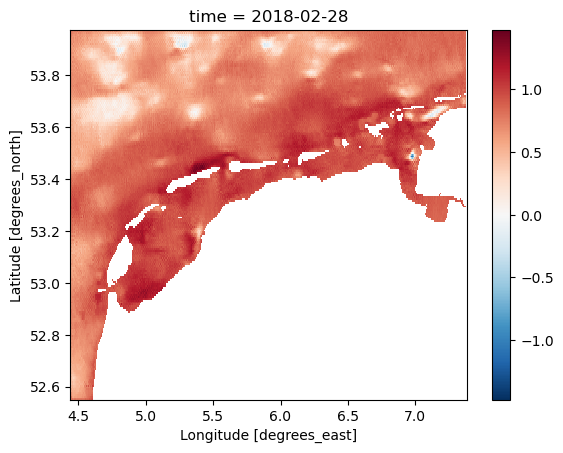

In [34]:
# test_pred.shape
(test_pred[-1]*landmask.mask.values).plot()  # the last day of February 2018